# Model finding (Bagging)

This notebook will work finding the best model to make predictions on our datas 

**Main goals are**: 
- Optimize predictions by aggregating models

In [1]:
# Retreiving a significative amount of data
from local_lib.dataset import retreiveDatasetFromCsv

dataset = retreiveDatasetFromCsv(src="../../datasets/chest_Xray/_processed_resize_small/_processed_dfs")
dataset = dataset.sample(frac=1, random_state=42)

In [2]:
dataset.iloc[0]["pixel_value"]

array([ 31,  37,  63, ..., 202, 204, 207], dtype=int64)

**We use a custom flatten mask to make our data compatible with machine learning models**

In [2]:
from local_lib.flatten_transformer import FlattenTransformer
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('image_mask', FlattenTransformer()),
])

# Fit and transform data
X = pipeline.fit_transform(dataset["pixel_value"])
y = np.array(list(dataset["class"]))

In [5]:
import numpy as np
np.shape(X)

(5856, 20130)

In [6]:
np.unique(y)

array([0, 1, 2])

### Now we try to extend to 3 classes

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [5]:
# First of all we will use a DummyClassifier to get an idea of what a uncorrelated model looks like
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
ac = dummy_clf.score(X_test, y_test)
print("Using randomly generated answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using only most frequent number as answer we get " + str(ac) + "% Accuracy")

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
ac = round(dummy_clf.score(X_test, y_test) * 100, 2)
print("Using uniform distribution answer we get " + str(ac) + "% Accuracy")

Using randomly generated answer we get 0.3616140713916192% Accuracy
Using only most frequent number as answer we get 47.9% Accuracy
Using uniform distribution answer we get 33.26% Accuracy


### We display base performance of model

Test Accuracy: 0.71
Test Precision: 0.74
Test Recall: 0.71
Confusion matrix:



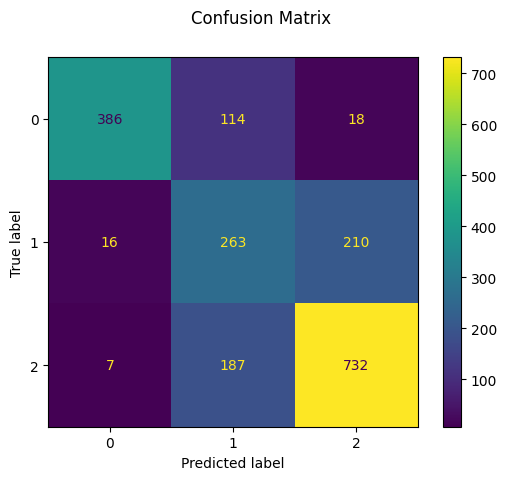

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import  GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score


pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
y_pred_simpler = pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()

**We will create a pool of model to combine predictions**

**Voting classifier** is a good starting point to see what mask and scaler can bring to each other

In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler

knn_combined = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_geo = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="geometry")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_seuil = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="baseline")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample = Pipeline([
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])
knn_sample_minmax = Pipeline([
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_sample_standard = Pipeline([
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_minmax = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
knn_combined_standard = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

eclf1 = VotingClassifier(estimators=[
    ('knn_combined', knn_combined),
    ('knn_geo', knn_geo),
    ('knn_seuil', knn_seuil),
    ('knn_sample', knn_sample),
    ('knn_sample_minmax', knn_sample_minmax),
    ('knn_sample_standard', knn_sample_standard),
    ('knn_combined_minmax', knn_combined_minmax),
    ('knn_combined_standard', knn_combined_standard)],
    voting='soft')

eclf1 = eclf1.fit(X_train, y_train)

y_pred_simpler = eclf1.predict(X_test)

train_accuracy = accuracy_score(y_test, y_pred_simpler)
train_precision = precision_score(y_test, y_pred_simpler, average="weighted")
train_recall = recall_score(y_test, y_pred_simpler, average="weighted")

In [14]:
print(f"Test Accuracy: {train_accuracy:.2f}")
print(f"Test Precision: {train_precision:.2f}")
print(f"Test Recall: {train_recall:.2f}")

Test Accuracy: 0.75
Test Precision: 0.76
Test Recall: 0.75


Test Accuracy: 0.75
Test Precision: 0.76
Test Recall: 0.75
Confusion matrix:



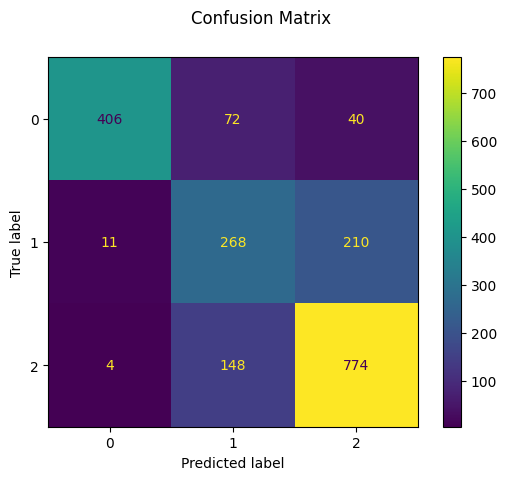

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import  GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score

y_pred_simpler = eclf1.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()

This simple aggregation helped us reaching better results

Now we will use more advanced aggregation techniques <br>
**Bagging classifier**

Test Accuracy: 0.71
Test Precision: 0.73
Test Recall: 0.71
Confusion matrix:



NameError: name 'plt' is not defined

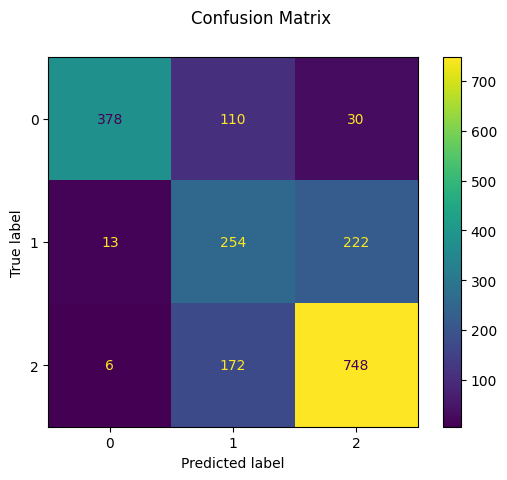

In [4]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

knn_combined = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy="combined")),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

clf = BaggingClassifier(estimator=knn_combined,
                        n_estimators=30, random_state=0).fit(X_train, y_train)

y_pred_simpler = clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_simpler)
test_precision = precision_score(y_test, y_pred_simpler, average="weighted")
test_recall = recall_score(y_test, y_pred_simpler, average="weighted")

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix")

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")

print(f"Confusion matrix:\n")
plt.show()

If we keep with accuracy, no mask seems to be better, and the model is making a lot of errors between bacteria and virus detection

In [28]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score

param_grid = ["combined", "geometry", "baseline", "none"]

results = {
        "combined":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "geometry":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "baseline":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "none":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
}

for strategy in param_grid:
    print("Processing " +strategy+ "...")
    pipeline = Pipeline([
        ('image_mask', MaskSeuilTransformer(strategy=strategy)),
        ('knn', KNeighborsClassifier())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[strategy]["accuracies"] = pipeline.score(X_test, y_test)
    print("Mean accuracy :" + str(results[strategy]["accuracies"]))

    results[strategy]["recalls"] = recall_score(y_test, y_pred, average='weighted')
    print("Mean recall " + str(results[strategy]["recalls"]))

    results[strategy]["precisions"] = precision_score(y_test, y_pred, average='weighted')
    print("Mean precision " + str(results[strategy]["recalls"]))



Processing combined...
Mean accuracy :0.7227108122090016
Mean recall 0.7227108122090016
Mean precision 0.7227108122090016
Processing geometry...
Mean accuracy :0.7465080186239007
Mean recall 0.7465080186239007
Mean precision 0.7465080186239007
Processing baseline...
Mean accuracy :0.7403000517330575
Mean recall 0.7403000517330575
Mean precision 0.7403000517330575
Processing none...
Mean accuracy :0.7542679772374548
Mean recall 0.7542679772374548
Mean precision 0.7542679772374548


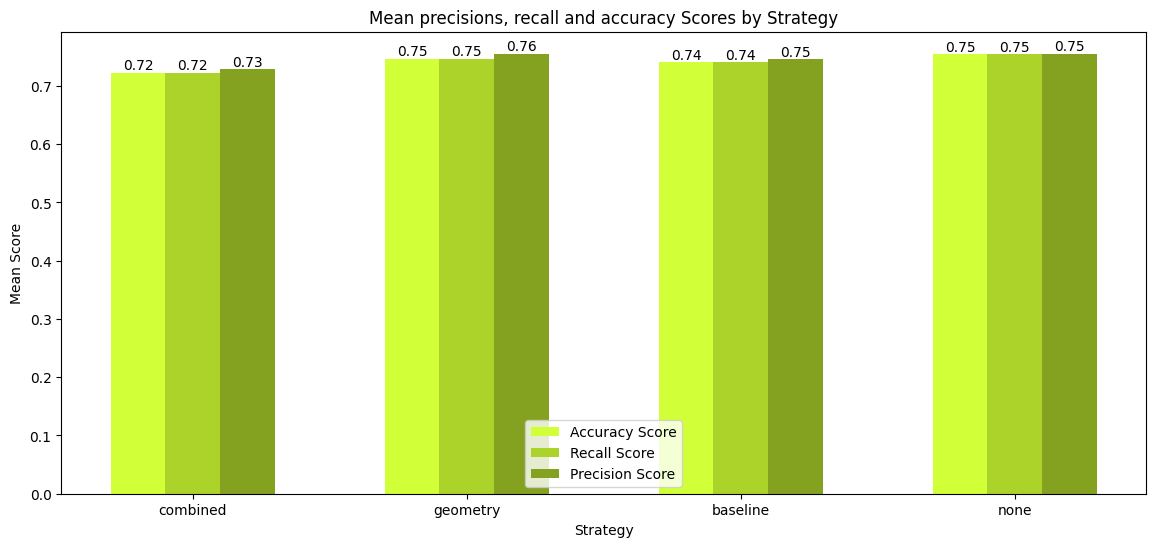

In [29]:
import matplotlib.pyplot as plt

# Calculate mean test and train scores for each split
param_grid = ["combined", "geometry", "baseline", "none"]

mean_accuracy = [results[strat]["accuracies"] for strat in param_grid]
mean_recall = [results[strat]["recalls"] for strat in param_grid]
mean_precision = [results[strat]["precisions"] for strat in param_grid]

# Strategy names
bar_width=0.2


# Plot bar chart for mean scores
plt.figure(figsize=(14, 6))
plt.bar(np.arange(len(param_grid)) - bar_width, mean_accuracy, width=bar_width, label='Accuracy Score', color='#D1FF38')
plt.bar(np.arange(len(param_grid)) + 0, mean_recall, width=bar_width, label='Recall Score', color='#ACD32A')
plt.bar(np.arange(len(param_grid)) + bar_width, mean_precision, width=bar_width, label='Precision Score', color='#84A21F')

i=0
for strat in param_grid:
    plt.text(i-bar_width, results[strat]["accuracies"], str(round(results[strat]["accuracies"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i, results[strat]["recalls"], str(round(results[strat]["recalls"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i+bar_width, results[strat]["precisions"], str(round(results[strat]["precisions"], 2)), ha='center', va='bottom')
    i+=1

plt.xticks(np.arange(len(param_grid)), param_grid)
plt.xlabel('Strategy')
plt.ylabel('Mean Score')
plt.title('Mean precisions, recall and accuracy Scores by Strategy')
plt.legend()
plt.show()

**Baseline mask**

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 80.83% Accuracy - [TrainSet]
Combined mask accuracy is around 74.19% Accuracy - [TestSet]


**Geometry mask**

In [51]:
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 81.26% Accuracy - [TrainSet]
Combined mask accuracy is around 74.13% Accuracy - [TestSet]


**Combined mask**

In [52]:
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 80.47% Accuracy - [TrainSet]
Combined mask accuracy is around 73.46% Accuracy - [TestSet]


**No mask**

In [17]:
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='none')),
    ('knn', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
accTrain = round(pipeline.score(X_train, y_train) * 100, 2)
accTest = round(pipeline.score(X_test, y_test) * 100, 2)
print("Combined mask accuracy is around " + str(accTrain) + "% Accuracy - [TrainSet]")
print("Combined mask accuracy is around " + str(accTest) + "% Accuracy - [TestSet]")

Combined mask accuracy is around 81.11% Accuracy - [TrainSet]
Combined mask accuracy is around 75.43% Accuracy - [TestSet]


**Checking for scalers using previoulsy found mask** (geometry)

In [8]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from local_lib.testerTransformer import TesterTransformer
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.neighbors import KNeighborsClassifier

param_grid = ["StandardScaler", "MinMaxScaler", "Normalizer", "None"]

results = {
        "StandardScaler":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "MinMaxScaler":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "Normalizer":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "None":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
}

for strategy in param_grid:
    print("Processing " +strategy+ "...")
    pipeline = Pipeline([
        ('image_mask', MaskSeuilTransformer(strategy='geometry')),
        ('tester_tr', TesterTransformer(strategy=strategy)),
        ('knn', KNeighborsClassifier(n_neighbors=13))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[strategy]["accuracies"] = pipeline.score(X_test, y_test)
    print("Mean accuracy :" + str(results[strategy]["accuracies"]))

    results[strategy]["recalls"] = recall_score(y_test, y_pred, average='weighted')
    print("Mean recall " + str(results[strategy]["recalls"]))

    results[strategy]["precisions"] = precision_score(y_test, y_pred, average='weighted')
    print("Mean precision " + str(results[strategy]["recalls"]))



Processing StandardScaler...
Mean accuracy :0.7490946714950854
Mean recall 0.7490946714950854
Mean precision 0.7490946714950854
Processing MinMaxScaler...
Mean accuracy :0.7594412829798242
Mean recall 0.7594412829798242
Mean precision 0.7594412829798242
Processing Normalizer...
Mean accuracy :0.7387480600103467
Mean recall 0.7387480600103467
Mean precision 0.7387480600103467
Processing None...
Mean accuracy :0.7387480600103467
Mean recall 0.7387480600103467
Mean precision 0.7387480600103467


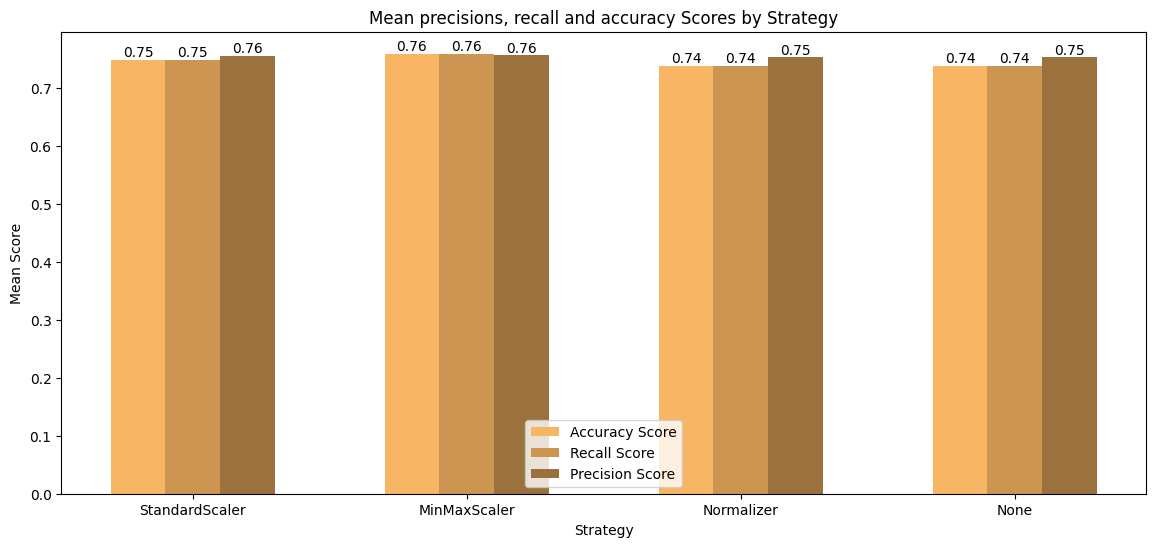

In [9]:
# Calculate mean test and train scores for each split
param_grid = ["StandardScaler", "MinMaxScaler", "Normalizer", "None"]

mean_accuracy = [results[strat]["accuracies"] for strat in param_grid]
mean_recall = [results[strat]["recalls"] for strat in param_grid]
mean_precision = [results[strat]["precisions"] for strat in param_grid]

# Strategy names
bar_width=0.2


# Plot bar chart for mean scores
plt.figure(figsize=(14, 6))
plt.bar(np.arange(len(param_grid)) - bar_width, mean_accuracy, width=bar_width, label='Accuracy Score', color='#F8B664')
plt.bar(np.arange(len(param_grid)) + 0, mean_recall, width=bar_width, label='Recall Score', color='#CC9552')
plt.bar(np.arange(len(param_grid)) + bar_width, mean_precision, width=bar_width, label='Precision Score', color='#9B713E')

i=0
for strat in param_grid:
    plt.text(i-bar_width, results[strat]["accuracies"], str(round(results[strat]["accuracies"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i, results[strat]["recalls"], str(round(results[strat]["recalls"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i+bar_width, results[strat]["precisions"], str(round(results[strat]["precisions"], 2)), ha='center', va='bottom')
    i+=1

plt.xticks(np.arange(len(param_grid)), param_grid)
plt.xlabel('Strategy')
plt.ylabel('Mean Score')
plt.title('Mean precisions, recall and accuracy Scores by Strategy')
plt.legend()
plt.show()

**MinMax scaler get better results**

**StandardScaler**

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8050833333333334
Mean validation score: 0.7316666666666667


**MinMaxScaler**

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8087500000000001
Mean validation score: 0.7286666666666666


**Normalizer**

In [21]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='baseline')),
    ('std_scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

cv_results = cross_validate(pipeline, X, y, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8045833333333332
Mean validation score: 0.7230000000000001


### **Now we look for the best n_neighbors params setup**

In [11]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from local_lib.mask_transformer import MaskSeuilTransformer
from sklearn.neighbors import KNeighborsClassifier

param_grid = ["5", "8", "10", "13", "16"]

results = {
        "5":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "8":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "10":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "13":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "16":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
}

for n_neighbor in param_grid:
    print("Processing n=" +str(n_neighbor)+ "...")
    pipeline = Pipeline([
        ('image_mask', MaskSeuilTransformer(strategy='geometry')),
        ('minmax', MinMaxScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=int(n_neighbor)))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[str(n_neighbor)]["accuracies"] = pipeline.score(X_test, y_test)
    print("Mean accuracy :" + str(results[str(n_neighbor)]["accuracies"]))

    results[str(n_neighbor)]["recalls"] = recall_score(y_test, y_pred, average='weighted')
    print("Mean recall " + str(results[str(n_neighbor)]["recalls"]))

    results[str(n_neighbor)]["precisions"] = precision_score(y_test, y_pred, average='weighted')
    print("Mean precision " + str(results[str(n_neighbor)]["recalls"]))



Processing n=5...
Mean accuracy :0.7413347128815313
Mean recall 0.7413347128815313
Mean precision 0.7413347128815313
Processing n=8...
Mean accuracy :0.7434040351784791
Mean recall 0.7434040351784791
Mean precision 0.7434040351784791
Processing n=10...
Mean accuracy :0.7454733574754268
Mean recall 0.7454733574754268
Mean precision 0.7454733574754268
Processing n=13...
Mean accuracy :0.7553026383859286
Mean recall 0.7553026383859286
Mean precision 0.7553026383859286
Processing n=16...
Mean accuracy :0.7542679772374548
Mean recall 0.7542679772374548
Mean precision 0.7542679772374548


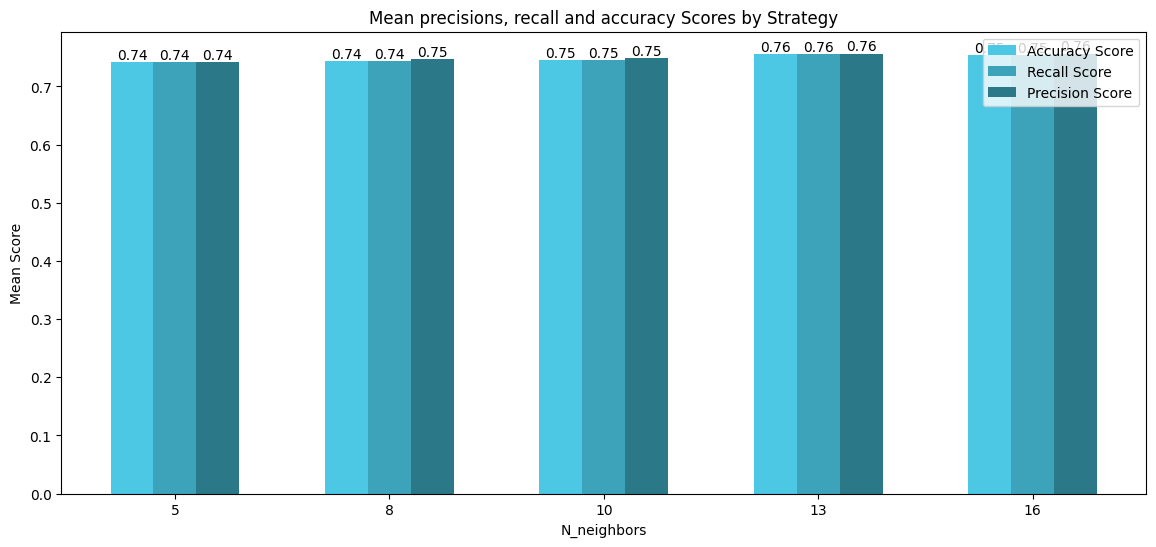

In [13]:
# Calculate mean test and train scores for each split
param_grid = ["5", "8", "10", "13", "16"]

mean_accuracy = [results[strat]["accuracies"] for strat in param_grid]
mean_recall = [results[strat]["recalls"] for strat in param_grid]
mean_precision = [results[strat]["precisions"] for strat in param_grid]

# Strategy names
bar_width=0.2


# Plot bar chart for mean scores
plt.figure(figsize=(14, 6))
plt.bar(np.arange(len(param_grid)) - bar_width, mean_accuracy, width=bar_width, label='Accuracy Score', color='#4CC8E4')
plt.bar(np.arange(len(param_grid)) + 0, mean_recall, width=bar_width, label='Recall Score', color='#3DA3BB')
plt.bar(np.arange(len(param_grid)) + bar_width, mean_precision, width=bar_width, label='Precision Score', color='#2B7889')

i=0
for strat in param_grid:
    plt.text(i-bar_width, results[strat]["accuracies"], str(round(results[strat]["accuracies"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i, results[strat]["recalls"], str(round(results[strat]["recalls"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i+bar_width, results[strat]["precisions"], str(round(results[strat]["precisions"], 2)), ha='center', va='bottom')
    i+=1

plt.xticks(np.arange(len(param_grid)), param_grid)
plt.xlabel('N_neighbors')
plt.ylabel('Mean Score')
plt.title('Mean precisions, recall and accuracy Scores by Strategy')
plt.legend()
plt.show()

In [26]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {'knn__n_neighbors': range(1,20)}

model = GridSearchCV(
    pipeline,
    param_grid=param_grid
).fit(X, y)

ac = round(model.score(X_test, y_test) * 100, 2)
print("Scaled data upon knn accuracy is around " + str(ac) + "% Accuracy")
model.best_params_

Scaled data upon knn accuracy is around 75.15% Accuracy


{'knn__n_neighbors': 13}

**Value found produce a lower accuracy score but if we look bellow it stopped overfitting**

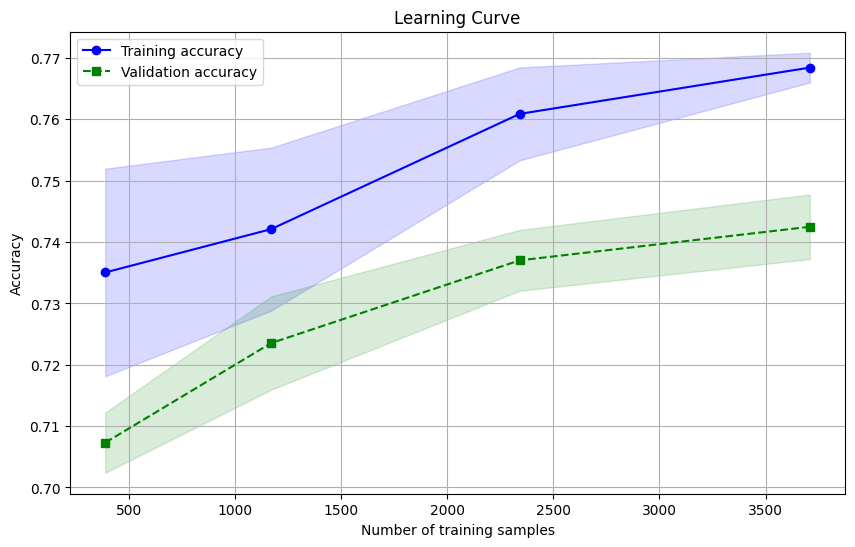

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X,
    y=y,
    train_sizes=[0.1, 0.3, 0.6, 0.95],
    n_jobs=8,
    cv=3,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Confusion matrix:
[[376  76  75]
 [ 14 266 201]
 [  8 114 803]]


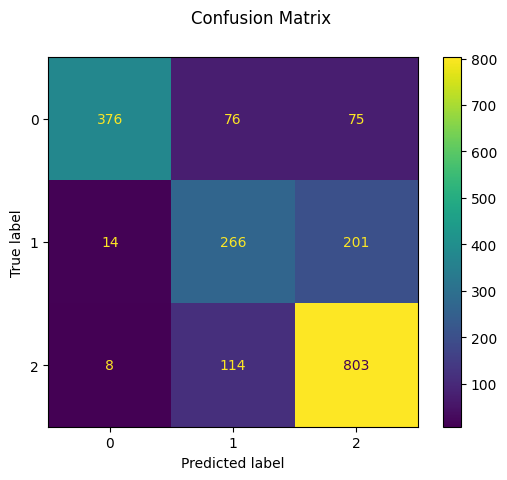

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()


**We effectivly lowered false positive from our predictions**, again the accuracy and precisions are a bit lower but it is not what we are looking for in this situation

**Model is still confused on choosing wether or not it is bacteria or virus pneumonia**

### We reached a point of stagnation regarding all possibilities we listed
Now we are going to dig deeper into data repartition

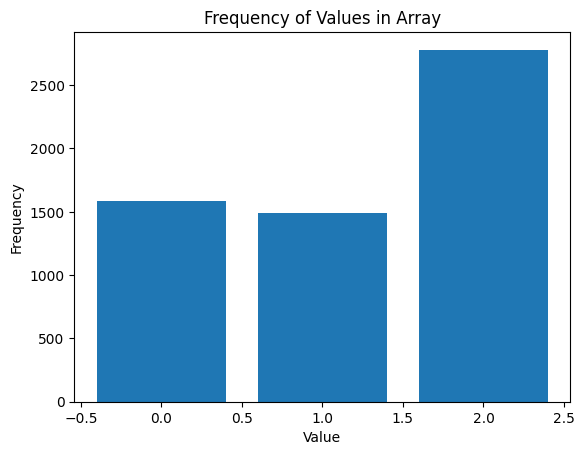

In [35]:
from collections import Counter


counter = Counter(y)

# Convert Counter to dictionary
grouped = dict(counter)

# Extract keys and values
keys = list(grouped.keys())
values = list(grouped.values())

# Plot the bar chart
plt.bar(keys, values)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Frequency of Values in Array')
plt.show()


**Bacteria is almost twice as much represented in this dataset**<br>
It may leads to prediction issue with overweighted point of interest in images

We try to reequilibrate the dataset

In [36]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import numpy as np

# Before applying SMOTE
print("Class distribution before SMOTE:")
print("Class 0:", sum(y == 0))
print("Class 1:", sum(y == 1))
print("Class 2:", sum(y == 2))

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# After applying SMOTE
print("\nClass distribution after SMOTE:")
print("Class 0:", sum(y_resampled == 0))
print("Class 1:", sum(y_resampled == 1))
print("Class 2:", sum(y_resampled == 2))


Class distribution before SMOTE:
Class 0: 1583
Class 1: 1493
Class 2: 2780

Class distribution after SMOTE:
Class 0: 2780
Class 1: 2780
Class 2: 2780


In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=13))
])

cv_results = cross_validate(pipeline, X_resampled, y_resampled, cv=3, return_train_score=True, n_jobs=4)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.7708633093525181
Mean validation score: 0.7310551558752998


Confusion matrix:
[[798 125   5]
 [ 29 794 111]
 [ 13 428 450]]


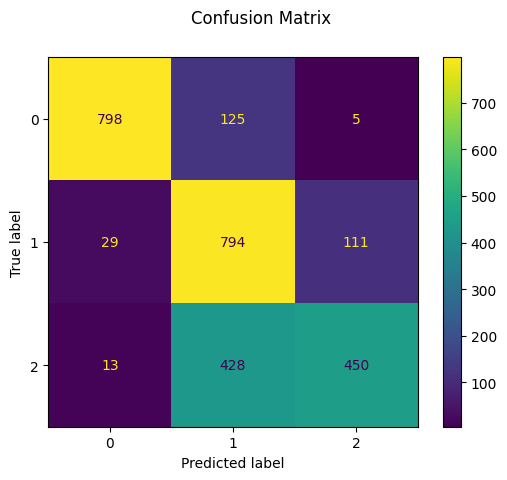

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resampled, y_resampled, test_size=0.33, random_state=0)

pipeline.fit(X_train_r, y_train_r)
y_pred_r = pipeline.predict(X_test_r)

disp = ConfusionMatrixDisplay.from_predictions(y_test_r, y_pred_r)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()


**Balancing data incresaed confusion and decreased accuracy, precision and recall**

**No improvments at all**

## **Switching to linear SVC to see if any changes**

In [9]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', MinMaxScaler()),
    ('knn', LinearSVC())
])

cv_results = cross_validate(pipeline, X, y, n_jobs=8, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.9879607045761725
Mean validation score: 0.7178991439888314


**Testing poly svc version**

In [13]:
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='geometry')),
    ('std_scaler', MinMaxScaler()),
    ('knn', svm.SVC(kernel="poly", degree=4, C=1.5))
])

cv_results = cross_validate(pipeline, X[:1000], y[:1000], n_jobs=8, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.9942500000000001
Mean validation score: 0.693


Way too much overfit

**RBF version**

In [49]:
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from local_lib.mask_transformer import MaskSeuilTransformer

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('std_scaler', MinMaxScaler()),
    ('svm', svm.SVC(kernel="rbf"))
])

cv_results = cross_validate(pipeline, X_resampled[:2500], y_resampled[:2500], n_jobs=8, cv=5, return_train_score=True)

print("Mean train score:", cv_results['train_score'].mean())
print("Mean validation score:", cv_results['test_score'].mean())

Mean train score: 0.8103
Mean validation score: 0.7732


**Choosing rbf kernel since it provide some coherent values**<br>
Now we look for the most suitable mask

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import svm
from local_lib.mask_transformer import MaskSeuilTransformer
import threading

param_grid = ["combined", "geometry", "baseline", "none"]

results = {
        "combined":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "geometry":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "baseline":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
        "none":{
            "accuracies" : [],
            "recalls" : [],
            "precisions" : [],
            },
}

def training_task(strategy, X_train, y_train,X_test,y_test):
    print("Processing " +strategy+ "...")
    pipeline = Pipeline([
        ('image_mask', MaskSeuilTransformer(strategy=strategy)),
        ('knn', svm.SVC(kernel="rbf"))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results[strategy]["accuracies"] = pipeline.score(X_test, y_test)
    print("Mean accuracy :" + str(results[strategy]["accuracies"]))

    results[strategy]["recalls"] = recall_score(y_test, y_pred, average='weighted')
    print("Mean recall " + str(results[strategy]["recalls"]))

    results[strategy]["precisions"] = precision_score(y_test, y_pred, average='weighted')
    print("Mean precision " + str(results[strategy]["recalls"]))


threads = []
for strategy in param_grid:
    threads.append(threading.Thread(target=training_task, args=(strategy, X_train, y_train, X_test, y_test)))

for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

Processing combined...
Processing geometry...
Processing baseline...
Processing none...
Mean accuracy :0.7868598034143818
Mean recall 0.7868598034143818
Mean precision 0.7868598034143818
Mean accuracy :0.784790481117434
Mean recall 0.784790481117434
Mean precision 0.784790481117434
Mean accuracy :0.7718572167615106
Mean recall 0.7718572167615106
Mean precision 0.7718572167615106
Mean accuracy :0.7728918779099845
Mean recall 0.7728918779099845
Mean precision 0.7728918779099845


In [5]:
results

{'combined': {'accuracies': 0.7728918779099845,
  'recalls': 0.7728918779099845,
  'precisions': 0.7693616176554257},
 'geometry': {'accuracies': 0.784790481117434,
  'recalls': 0.784790481117434,
  'precisions': 0.7781262819191319},
 'baseline': {'accuracies': 0.7718572167615106,
  'recalls': 0.7718572167615106,
  'precisions': 0.7652633613868882},
 'none': {'accuracies': 0.7868598034143818,
  'recalls': 0.7868598034143818,
  'precisions': 0.7791828495187014}}

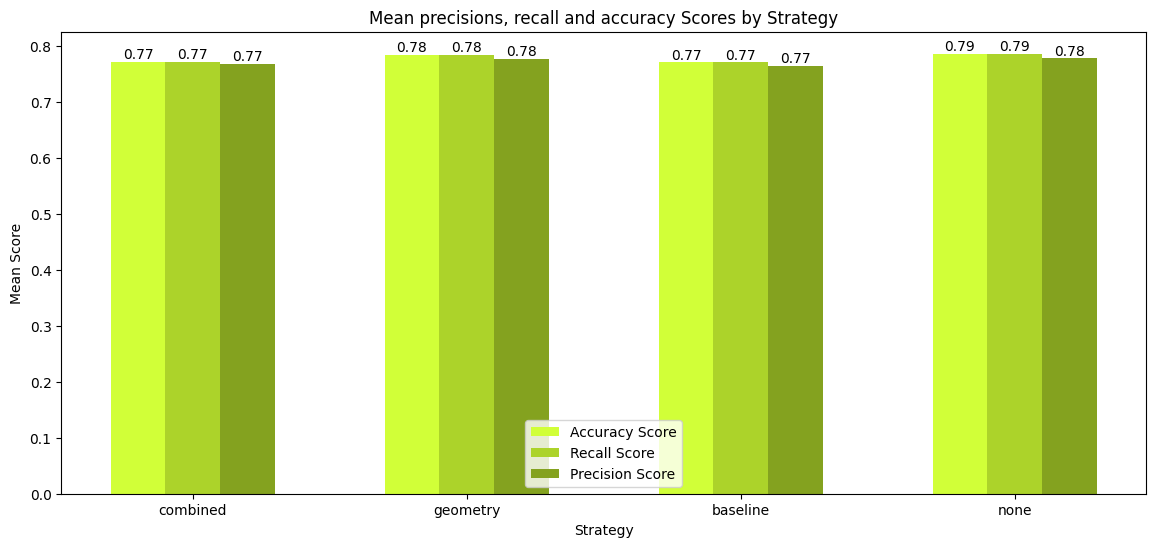

In [7]:
import matplotlib.pyplot as plt

# Calculate mean test and train scores for each split
param_grid = ["combined", "geometry", "baseline", "none"]

mean_accuracy = [results[strat]["accuracies"] for strat in param_grid]
mean_recall = [results[strat]["recalls"] for strat in param_grid]
mean_precision = [results[strat]["precisions"] for strat in param_grid]

# Strategy names
bar_width=0.2


# Plot bar chart for mean scores
plt.figure(figsize=(14, 6))
plt.bar(np.arange(len(param_grid)) - bar_width, mean_accuracy, width=bar_width, label='Accuracy Score', color='#D1FF38')
plt.bar(np.arange(len(param_grid)) + 0, mean_recall, width=bar_width, label='Recall Score', color='#ACD32A')
plt.bar(np.arange(len(param_grid)) + bar_width, mean_precision, width=bar_width, label='Precision Score', color='#84A21F')

i=0
for strat in param_grid:
    plt.text(i-bar_width, results[strat]["accuracies"], str(round(results[strat]["accuracies"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i, results[strat]["recalls"], str(round(results[strat]["recalls"], 2)), ha='center', va='bottom')
    i+=1

i=0
for strat in param_grid:
    plt.text(i+bar_width, results[strat]["precisions"], str(round(results[strat]["precisions"], 2)), ha='center', va='bottom')
    i+=1

plt.xticks(np.arange(len(param_grid)), param_grid)
plt.xlabel('Strategy')
plt.ylabel('Mean Score')
plt.title('Mean precisions, recall and accuracy Scores by Strategy')
plt.legend()
plt.show()

**No mask seems to have a better overall effect on data**
<br> 
This may be due to model change

Confusion matrix:
[[471  23  20]
 [ 47 209 233]
 [ 25  61 844]]


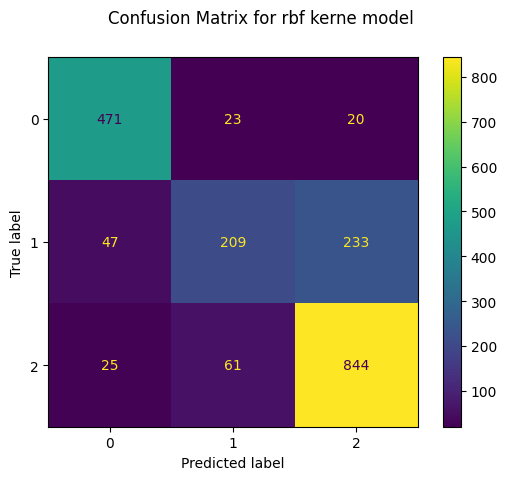

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import svm

pipeline = Pipeline([
    ('knn', svm.SVC(kernel="rbf"))
])

pipeline.fit(X_train, y_train)
print("training finished")
y_pred_simpler = pipeline.predict(X_test)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix for rbf kerne model")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

**More confusion on model**

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from local_lib.testerTransformer import TesterTransformer
from sklearn import svm
import numpy as np

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('tester_tr', TesterTransformer()),
    ('svm', svm.SVC(kernel="rbf"))
])

param_grid = {
             'tester_tr__strategy' : ["StandardScaler","MinMaxScaler","Normalizer", "None"]
              }

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=3,
                    cv=3,
                    n_jobs=8,
                    scoring='accuracy',
                    random_state=42).fit(X_resampled[:1500], y_resampled[:1500])


ac = round(random_search.score(X_test, y_test) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 79.93% Accuracy


{'tester_tr__strategy': 'StandardScaler'}

**StandardScaler again seems to work well**

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from local_lib.testerTransformer import TesterTransformer
from sklearn import svm
import numpy as np

pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('tester_tr', StandardScaler()),
    ('svm', svm.SVC(kernel="rbf"))
])

param_grid = {
              'svm__C': np.linspace(1, 3, num=8)
              }

random_search = RandomizedSearchCV(
                    pipeline,
                    param_distributions=param_grid, 
                    n_iter=8,
                    cv=3,
                    n_jobs=8,
                    scoring='accuracy',
                    random_state=42).fit(X_resampled[:1500], y_resampled[:1500])


ac = round(random_search.score(X_test, y_test) * 100, 2)
print("Randomized search acheived " + str(ac) + "% Accuracy")
random_search.best_params_

Randomized search acheived 81.89% Accuracy


{'svm__C': 1.8571428571428572}

**C: 1.8571428571428572**

training finished
Confusion matrix:
[[476  26  12]
 [ 43 242 204]
 [ 20  81 829]]


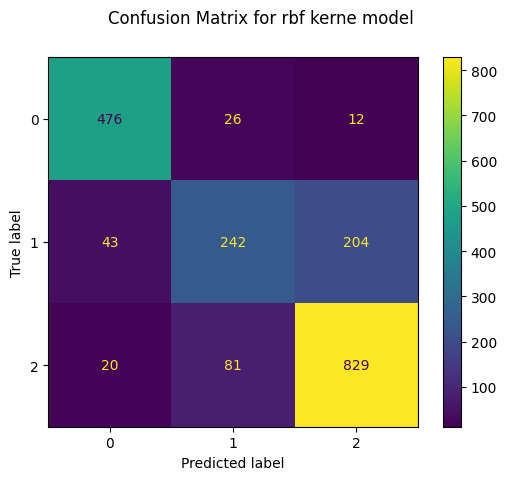

In [15]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import svm

pipeline = Pipeline([
    ('tester_tr', StandardScaler()),
    ('knn', svm.SVC(kernel="rbf", C=1.857))
])

pipeline.fit(X_train, y_train)
print("training finished")
y_pred_simpler = pipeline.predict(X_test)

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_simpler)
disp.figure_.suptitle("Confusion Matrix for rbf kerne model")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

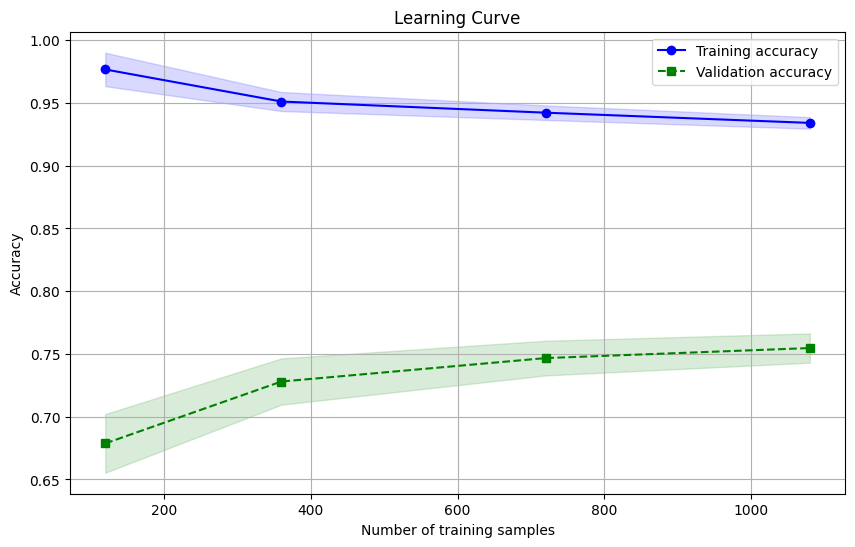

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Define your pipeline
pipeline = Pipeline([
    ('image_mask', MaskSeuilTransformer(strategy='combined')),
    ('std_scaler', StandardScaler()),
    ('svm', svm.SVC(kernel="rbf", C=1.85))
])

# Plot learning curves for the best parameters
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_resampled[:1500],
    y=y_resampled[:1500],
    train_sizes=[0.1, 0.3, 0.6, 0.9],
    n_jobs=8,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and standard deviation of training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


We also end up with overfitting problems

### Recap:
 - KNN : 
    - 75% accuracy
    - 72% precision
    - 74% recall
    - confused matrix on pneumonia type
    - limited false positives
 - SVM(rbf) : 
    - 86% accuracy
    - 78% precision
    - 77% recall
    - confused matrix on pneumonia type
    - overfitting learning curve

Conclusion : 

Why is the knn still the best option ?
 - Recall and precision, as it is a 3 class prediction, are an average of mistakes and do not represent false positive in this specific case, in fact : 
    - **SVM** has predicted 72 infected lungs as clean scan and 43 clean scan as infected lungs
    - Wich is less than the 22 infected lungs as clean scan and 141 clean scan as infected lungs from **KNN**
    - **BUT** we really care about not predicting clean scan when they are not, in that cas knn perform better
 - Svm also clearly overfit, even if testing results are better it show that the model is to correlated with training data, and we have no garantee that we will have this quality of prediction on new unseen datas 